# Import libraries, load and transform data

In [1]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 2>/dev/null

In [2]:
# Importing necessary libraries and modules
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler # import RandomUnderSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Import necessary libraries
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import os
MIN_SAMPLES = 100 # only include labels with as many samples
# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Iterate through all image files in the specified directory
for file in sorted((Path('/kaggle/input/flowers/flowers/').glob('*/*.jpg'))):
    # check number of such files in a directory
    sample_dir = '/'.join(str(file).split('/')[:-1])+'/'
    num_files_in_dir = [len(x) for _, _, x in os.walk(sample_dir)][0]
    if num_files_in_dir >= MIN_SAMPLES:
        file_names.append(str(file))  # Add the file path to the list
        label = str(file).split('/')[-2]  # Extract the label from the file path
        labels.append(label)  # Add the label to the list

# Print the total number of file names and labels
print(len(file_names), len(labels), len(set(labels)))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

15740 15740 16


In [5]:
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()

print(df.shape)

(16864, 2)


In [6]:
df['label'].value_counts().head(50)

label
astilbe             1054
bellflower          1054
black_eyed_susan    1054
calendula           1054
california_poppy    1054
carnation           1054
common_daisy        1054
coreopsis           1054
daffodil            1054
dandelion           1054
iris                1054
magnolia            1054
rose                1054
sunflower           1054
tulip               1054
water_lily          1054
Name: count, dtype: int64

In [7]:
# Create a dataset from a Pandas DataFrame.
dataset = Dataset.from_pandas(df).cast_column("image", Image())

In [11]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = ['calendula', 'coreopsis', 'rose', 'black_eyed_susan', 'water_lily', 'california_poppy', 
               'dandelion', 'magnolia', 'astilbe', 'sunflower', 'tulip', 'bellflower', 'iris', 
               'common_daisy', 'daffodil', 'carnation'] #list(set(labels))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'calendula', 1: 'coreopsis', 2: 'rose', 3: 'black_eyed_susan', 4: 'water_lily', 5: 'california_poppy', 6: 'dandelion', 7: 'magnolia', 8: 'astilbe', 9: 'sunflower', 10: 'tulip', 11: 'bellflower', 12: 'iris', 13: 'common_daisy', 14: 'daffodil', 15: 'carnation'} 

Mapping of Labels to IDs: {'calendula': 0, 'coreopsis': 1, 'rose': 2, 'black_eyed_susan': 3, 'water_lily': 4, 'california_poppy': 5, 'dandelion': 6, 'magnolia': 7, 'astilbe': 8, 'sunflower': 9, 'tulip': 10, 'bellflower': 11, 'iris': 12, 'common_daisy': 13, 'daffodil': 14, 'carnation': 15}


In [12]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 60-40 split ratio.
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Map:   0%|          | 0/16864 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/16864 [00:00<?, ? examples/s]

In [13]:
# Define the pre-trained ViT model string
model_str = "dima806/flowers_16_types_image_detection" #'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation up to 30 degrees
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

Size:  224


In [14]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

In [15]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    
    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])
    
    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

# Load, train, and evaluate model

In [16]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

85.81096


In [17]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions
    
    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids
    
    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)
    
    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    
    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }

In [25]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "flowers_16_types_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 5

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,
    
    # Specify the directory where training logs will be stored.
    logging_dir='./logs',
    
    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",
    
    # Set the learning rate for the optimizer.
    learning_rate=1e-6,
    
    # Define the batch size for training on each device.
    per_device_train_batch_size=32,
    
    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=8,
    
    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,
    
    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,
    
    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,
    
    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,
    
    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',
    
    # Load the best model at the end of training.
    load_best_model_at_end=True,
    
    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,
    
    # Specify that training progress should not be reported.
    report_to="none" 
)

In [26]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [27]:
trainer.evaluate()

{'eval_loss': 0.1383843570947647,
 'eval_model_preparation_time': 0.0052,
 'eval_accuracy': 0.9942187963237474,
 'eval_runtime': 64.1211,
 'eval_samples_per_second': 105.207,
 'eval_steps_per_second': 13.163}

In [28]:
# Start training the model using the trainer object.
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,No log,0.133717,0.005200,0.994071
2,0.125900,0.131013,0.005200,0.994219
3,0.125900,0.128378,0.005200,0.994367
4,0.120700,0.126704,0.005200,0.994219
5,0.115800,0.126295,0.005200,0.994367


TrainOutput(global_step=1585, training_loss=0.1204206442607314, metrics={'train_runtime': 1465.9353, 'train_samples_per_second': 34.51, 'train_steps_per_second': 1.081, 'total_flos': 3.920811666805555e+18, 'train_loss': 0.1204206442607314, 'epoch': 5.0})

In [29]:
trainer.evaluate()

{'eval_loss': 0.12629546225070953,
 'eval_model_preparation_time': 0.0052,
 'eval_accuracy': 0.9943670323154462,
 'eval_runtime': 63.8755,
 'eval_samples_per_second': 105.612,
 'eval_steps_per_second': 13.213,
 'epoch': 5.0}

In [30]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.12629546225070953, 'test_model_preparation_time': 0.0052, 'test_accuracy': 0.9943670323154462, 'test_runtime': 63.9983, 'test_samples_per_second': 105.409, 'test_steps_per_second': 13.188}


Accuracy: 0.9944
F1 Score: 0.9944


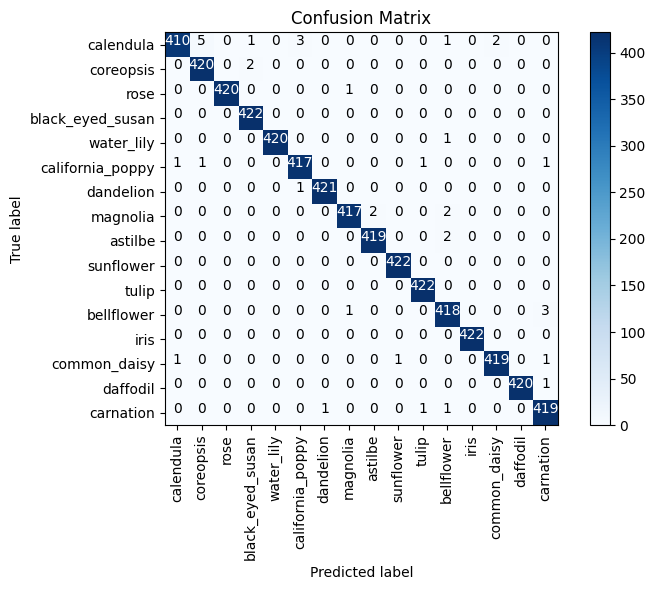


Classification report:

                  precision    recall  f1-score   support

       calendula     0.9951    0.9716    0.9832       422
       coreopsis     0.9859    0.9953    0.9906       422
            rose     1.0000    0.9976    0.9988       421
black_eyed_susan     0.9929    1.0000    0.9965       422
      water_lily     1.0000    0.9976    0.9988       421
california_poppy     0.9905    0.9905    0.9905       421
       dandelion     0.9976    0.9976    0.9976       422
        magnolia     0.9952    0.9905    0.9929       421
         astilbe     0.9952    0.9952    0.9952       421
       sunflower     0.9976    1.0000    0.9988       422
           tulip     0.9953    1.0000    0.9976       422
      bellflower     0.9835    0.9905    0.9870       422
            iris     1.0000    1.0000    1.0000       422
    common_daisy     0.9952    0.9929    0.9941       422
        daffodil     1.0000    0.9976    0.9988       421
       carnation     0.9859    0.9929    0.989

In [31]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 100:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [32]:
trainer.save_model()

In [45]:
from transformers import pipeline
pipe = pipeline('image-classification', model=model_name, device=0)

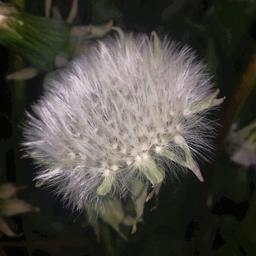

In [59]:
# Accessing an image from the 'test_data' dataset using index 1.
image = test_data[7]["image"]

# Displaying the 'image' variable.
image

In [60]:
# Apply the 'pipe' function to process the 'image' variable.
pipe(image)

[{'label': 'dandelion', 'score': 0.9914873838424683},
 {'label': 'carnation', 'score': 0.4757101535797119},
 {'label': 'sunflower', 'score': 0.4377260208129883},
 {'label': 'astilbe', 'score': 0.43647050857543945},
 {'label': 'black_eyed_susan', 'score': 0.4335806965827942}]

The predicted label for the image is: rose


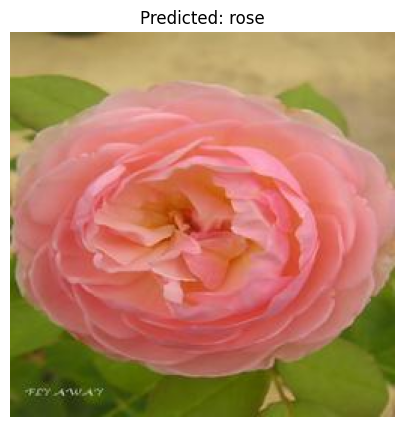

In [63]:
import torch
from PIL import Image
from torchvision import transforms
from transformers import AutoConfig, AutoModelForImageClassification
import matplotlib.pyplot as plt

# Define the folder where your model is saved
folder_name = '/kaggle/working/flowers_16_types_image_detection/checkpoint-1585/'

# Load the model configuration and weights
config = AutoConfig.from_pretrained(folder_name)
model = AutoModelForImageClassification.from_pretrained(folder_name, config=config)

# Set the model to evaluation mode
model.eval()

# Image preprocessing: ensure these transformations match your model's training setup
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Class-to-label mapping
label_map = {
    0: 'calendula', 1: 'coreopsis', 2: 'rose', 3: 'black_eyed_susan', 4: 'water_lily',
    5: 'california_poppy', 6: 'dandelion', 7: 'magnolia', 8: 'astilbe', 9: 'sunflower',
    10: 'tulip', 11: 'bellflower', 12: 'iris', 13: 'common_daisy', 14: 'daffodil', 15: 'carnation'
}

# Path to your input image
image_path = '/kaggle/input/flowers/flowers/rose/105796918_05f03f42c7_c.jpg'

# Load and preprocess the image
img = Image.open(image_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    outputs = model(img_tensor)
    logits = outputs.logits

# Get the predicted class index
predicted_class = torch.argmax(logits, dim=1).item()

# Map the predicted class index to the label
predicted_label = label_map[predicted_class]

# Output the result
print(f"The predicted label for the image is: {predicted_label}")

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')  # Hide axis
plt.show()
